In [ ]:
!pip install requests

In [ ]:
!pip install scipy

In [2]:
import os
import time
from datetime import datetime, timedelta
import xml.etree.ElementTree as ET
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

## Data Collection

In [ ]:
key = '' # API key 추가하기

In [ ]:
import os
import time
import requests
import pandas as pd
import xml.etree.ElementTree as ET
from datetime import datetime

time_of_day = 'morning' # 시간대 변경하기 (morning / afternoon / evening)
duration_min = 120
interval_sec = 10
today = datetime.now().strftime('%m%d')
filepath = f'data/{today}'
os.makedirs(filepath, exist_ok=True)
filename = os.path.join(filepath, f'all_{today}_{time_of_day}.csv')

def collect_all_data(key):
    try:
        url = f'http://swopenAPI.seoul.go.kr/api/subway/{key}/xml/realtimeStationArrival/ALL'
        response = requests.get(url)
        response.encoding = 'utf-8'
        root = ET.fromstring(response.content)
        rows = root.findall('row')
    
    except Exception as e:
        print(f'API request failed ({e})')
        return pd.DataFrame()
    
    if not rows:
        print('No data received')
        return pd.DataFrame()
    
    records = [{child.tag: child.text for child in row} for row in rows]
    df = pd.DataFrame(records)
    print(f'Collected {len(records)} records')
    return df

print(f'Starting {interval_sec} seconds interval data collection for {duration_min} minutes...\n')
try:
    total_rounds = (duration_min * 60) // interval_sec
    header_written = False

    for i in range(total_rounds):
        df_round = collect_all_data(key)

        if not df_round.empty:
            df_round.to_csv(
                filename,
                mode='a',
                header=not header_written,
                index=False,
                encoding='utf-8-sig'
            )
            header_written = True
        
        time.sleep(interval_sec)
    
    print(f'\nAll data collection saved as {filename}')

except KeyboardInterrupt:
    print('\nData collection interrupted by user')

## Preprocessing

### 서울 도시철도 열차운행시각표 전처리

In [1]:
import pandas as pd
from datetime import datetime

# 2호선 IN ↔ OUT 변환
def reverse_direction(row):
    if row['호선'] == 2:
        if row['방향'] == 'IN':
            return 'OUT'
        elif row['방향'] == 'OUT':
            return 'IN'
    return row['방향']

def filter_schedule(time_of_day):
    schedule_filename = '서울교통공사_서울 도시철도 열차운행시각표_20250430.csv'

    match time_of_day:
        case 'morning':
            start_time = datetime.strptime('07:30:00', '%H:%M:%S').time()
            end_time = datetime.strptime('09:30:00', '%H:%M:%S').time()
        case 'afternoon':
            start_time = datetime.strptime('17:00:00', '%H:%M:%S').time()
            end_time = datetime.strptime('19:00:00', '%H:%M:%S').time()
        case 'evening':
            start_time = datetime.strptime('21:00:00', '%H:%M:%S').time()
            end_time = datetime.strptime('23:00:00', '%H:%M:%S').time()
        case _:
            raise ValueError(f'Invalid time_of_day: {time_of_day}')
    
    schedule_df = pd.read_csv(schedule_filename, encoding='cp949')
    schedule_df['열차도착시간'] = pd.to_datetime(schedule_df['열차도착시간'], format='%H:%M:%S', errors='coerce')
    schedule_df = schedule_df[schedule_df['열차도착시간'].notna()].copy()
    schedule_df['방향'] = schedule_df.apply(reverse_direction, axis=1)

    excluded_stations = ['별내별가람', '오남', '자양', '진접']
    schedule_df = schedule_df[~schedule_df['역사명'].isin(excluded_stations)]

    station_name_map = {
        '공릉': '공릉(서울산업대입구)',
        '광나루': '광나루(장신대)',
        '군자': '군자(능동)',
        '굽은다리': '굽은다리(강동구민회관앞)',
        '남한산성입구': '남한산성입구(성남법원,검찰청)',
        '대흥': '대흥(서강대앞)',
        '몽촌토성': '몽촌토성(평화의문)',
        '상도': '상도(중앙대앞)',
        '상월곡': '상월곡(한국과학기술연구원)',
        '새절': '새절(신사)',
        '서울역': '서울',
        '숭실대입구': '숭실대입구(살피재)',
        '신정': '신정(은행정)',
        '쌍용': '쌍용(나사렛대)',
        '아차산': '아차산(어린이대공원후문)',
        '안암': '안암(고대병원앞)',
        '어린이대공원': '어린이대공원(세종대)',
        '오목교': '오목교(목동운동장앞)',
        '월곡': '월곡(동덕여대)',
        '월드컵경기장': '월드컵경기장(성산)',
        '응암': '응암순환(상선)',
        '이수': '총신대입구(이수)',
        '증산': '증산(명지대앞)',
        '천호': '천호(풍납토성)',
        '총신대입구': '총신대입구(이수)',
        '평택지제': '지제',
        '화랑대': '화랑대(서울여대입구)'
    }
    schedule_df['역사명'] = schedule_df['역사명'].map(lambda x: station_name_map.get(x, x))

    filtered = schedule_df[
        (schedule_df['열차도착시간'].dt.time >= start_time) &
        (schedule_df['열차도착시간'].dt.time <= end_time)
    ].copy()

    filtered = filtered.sort_values(by=['호선', '방향', '열차도착시간'])

    output_filename = schedule_filename.replace('.csv', f'_{time_of_day}_clean.csv')
    filtered.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f'Filtered schedule saved as {output_filename}')

# 세 번 실행
for time_slots in ['morning', 'afternoon', 'evening']:
    filter_schedule(time_slots)

C:\Users\yanghm\AppData\Local\Temp\ipykernel_6580\3797893929.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  schedule_df = pd.read_csv(schedule_filename, encoding='cp949')


Filtered schedule saved as 서울교통공사_서울 도시철도 열차운행시각표_20250430_morning_clean.csv


C:\Users\yanghm\AppData\Local\Temp\ipykernel_6580\3797893929.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  schedule_df = pd.read_csv(schedule_filename, encoding='cp949')


Filtered schedule saved as 서울교통공사_서울 도시철도 열차운행시각표_20250430_afternoon_clean.csv


C:\Users\yanghm\AppData\Local\Temp\ipykernel_6580\3797893929.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  schedule_df = pd.read_csv(schedule_filename, encoding='cp949')


Filtered schedule saved as 서울교통공사_서울 도시철도 열차운행시각표_20250430_evening_clean.csv


### 수집 데이터 전처리

In [ ]:
# # 16개 역 데이터 전처리 (e.g. 서울_0525_morning.csv)

# date = '0521' # 날짜 변경하기
# time_of_day = 'morning' # 시간대 변경하기 (morning / afternoon / evening)
# stations = ['강남', '고속터미널', '군포', '금정', '금천구청', '명동', '명일', '부평', '사당', '서울', '성수', '수리산', '신도림', '안암(고대병원앞)', '약수', '왕십리']

# # 시간 범위 변경하기
# start_time = datetime.strptime('07:30:00', '%H:%M:%S').time()
# end_time = datetime.strptime('09:30:00', '%H:%M:%S').time()

# columns = ['subwayId', 'updnLine', 'statnNm', 'btrainSttus', 'btrainNo', 'bstatnNm', 'recptnDt', 'arvlCd']

# for station in stations:
#     try:
#         filename = f'data/{date}/{station}_{date}_{time_of_day}.csv'

#         df = pd.read_csv(filename)
#         df['recptnDt'] = pd.to_datetime(df['recptnDt'], errors='coerce')

#         # 시간 범위 + 호선 (1-9호선만) 필터링
#         df = df[
#             df['recptnDt'].dt.time.between(start_time, end_time) &
#             df['subwayId'].astype(str).str[:4].astype(int).between(1001, 1009)
#         ]

#         # 2호선
#         is_line2 = df['subwayId'] == 1002
#         df_line2 = df[is_line2 & (df['arvlCd'] == 5)].copy()
#         df_line2['statnNm'] = df_line2['arvlMsg3']
#         df_line2 = df_line2[columns]

#         if not df_line2.empty:
#             df_line2 = df_line2.sort_values('recptnDt').drop_duplicates(
#                 subset=['btrainNo', 'subwayId', 'updnLine', 'statnNm'], keep='first'
#             )
#             for station_before in df_line2['statnNm'].unique():
#                 group = df_line2[df_line2['statnNm'] == station_before]
#                 filename_new = f'data/{date}/{station_before}_{date}_{time_of_day}_clean.csv'
#                 group.to_csv(filename_new, index=False, encoding='utf-8-sig')
#                 print(f'{station_before} saved as {filename_new}')

#         # 그 외 호선
#         df_other = df[~is_line2 & (df['arvlCd'] == 1)].copy()
#         df_other = df_other[columns]
#         if not df_other.empty:
#             df_other = df_other.sort_values('recptnDt').drop_duplicates(
#                 subset=['btrainNo', 'subwayId', 'updnLine', 'statnNm'], keep='first'
#             )
#             filename_new = f'data/{date}/{station}_{date}_{time_of_day}_clean.csv'
#             df_other.to_csv(filename_new, index=False, encoding='utf-8-sig')
#             print(f'{station} saved as {filename_new}')

#     except Exception as e:
#         print(f'Preprocessing failed for {station} ({e})')

In [42]:
# 일괄 데이터 전처리 (e.g. all_0529_morning.csv)
import os
import pandas as pd
from datetime import datetime, timedelta

seongsu_branch = {'성수지선', '용답', '신답', '용두', '신설동'}
sinjeong_branch = {'신도림지선', '도림천', '양천구청', '신정네거리', '까치산'}

def convert_direction(row):
    line = row['subwayId']
    station = row['statnNm']
    direction = row['updnLine']
    destination = row['bstatnNm']
    if line == 1002:
        if station == '성수' and destination == '성수지선':
            return '하행' if direction == '내선' else '상행'
        elif station == '신도림' and destination == '신도림지선':
            return '상행' if direction == '내선' else '하행'
        elif station in seongsu_branch and destination in seongsu_branch:
            return '하행' if direction == '내선' else '상행'
        elif station in sinjeong_branch and destination in sinjeong_branch:
            return '상행' if direction == '내선' else '하행'
    return direction

def preprocess_file(date, time_of_day):
    filename = f'data/{date}/all_{date}_{time_of_day}.csv'

    match time_of_day:
        case 'morning':
            start_time = datetime.strptime('07:30:00', '%H:%M:%S').time()
            end_time = datetime.strptime('09:30:00', '%H:%M:%S').time()
        case 'afternoon':
            start_time = datetime.strptime('17:00:00', '%H:%M:%S').time()
            end_time = datetime.strptime('19:00:00', '%H:%M:%S').time()
        case 'evening':
            start_time = datetime.strptime('21:00:00', '%H:%M:%S').time()
            end_time = datetime.strptime('23:00:00', '%H:%M:%S').time()
        case _:
            raise ValueError(f'Invalid time_of_day: {time_of_day}')
    
    columns = ['subwayId', 'updnLine', 'statnNm', 'btrainSttus', 'btrainNo', 'bstatnNm', 'recptnDt', 'arvlCd']

    try:
        df_all = pd.read_csv(filename)
        df_all['recptnDt'] = pd.to_datetime(df_all['recptnDt'], errors='coerce')

        # 시간 범위 + 호선 (1-9호선만) 필터링
        df_all = df_all[
            df_all['recptnDt'].dt.time.between(start_time, end_time) &
            df_all['subwayId'].astype(str).str[:4].astype(int).between(1001, 1009)
        ]

        # ——————————————————————————————
        # 2호선

        # 방향 보정
        df_all['updnLine'] = df_all.apply(convert_direction, axis=1)

        is_line2 = df_all['subwayId'] == 1002

        # arvlCd == 5: 전역 도착 (arvlMsg3의 전역을 statnNm으로)
        df2_5 = df_all[is_line2 & (df_all['arvlCd'] == 5)].copy()
        df2_5 = df2_5[df2_5['arvlMsg3'].notna()]
        df2_5['statnNm'] = df2_5['arvlMsg3']

        # 종합운동장 → 삼성 (recptnDt 시간 보정)
        df_samseong = df_all[
            is_line2 &
            (df_all['statnNm'] == '삼성') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '종합운동장')
        ].copy()
        df_samseong['recptnDt'] = df_samseong['recptnDt'] + timedelta(minutes=1)

        # 역삼 → 선릉 (recptnDt 시간 보정)
        df_seolleung = df_all[
            is_line2 &
            (df_all['statnNm'] == '선릉') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '역삼')
        ].copy()
        df_seolleung['recptnDt'] = df_seolleung['recptnDt'] + timedelta(minutes=1)

        # 한양대 → 뚝섬 (recptnDt 시간 보정)
        df_ttuksom = df_all[
            is_line2 &
            (df_all['statnNm'] == '뚝섬') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '한양대')
        ].copy()
        df_ttuksom['recptnDt'] = df_ttuksom['recptnDt'] + timedelta(minutes=1)

        # 성수 → 건대입구 (성수 도착 = 성수 출발 - recptnDt)
        df_seongsu = df_all[
            is_line2 &
            (df_all['statnNm'] == '건대입구') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '성수')
        ].copy()
        df_seongsu = df_seongsu[df_seongsu['arvlMsg3'].notna()]
        df_seongsu['statnNm'] = df_seongsu['arvlMsg3']
        df_seongsu['recptnDt'] = df_seongsu['recptnDt'] - timedelta(minutes=0.5)

        # 건대입구 → 성수 (recptnDt 시간 보정)
        df_konkukuniv_to_seongsu = df_all[
            is_line2 &
            (df_all['statnNm'] == '성수') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '건대입구')
        ].copy()
        df_konkukuniv_to_seongsu['recptnDt'] = df_konkukuniv_to_seongsu['recptnDt'] + timedelta(minutes=1)

        # 용두 → 신설동 (recptnDt 시간 보정)
        df_sinseoldong = df_all[
            is_line2 &
            (df_all['statnNm'] == '신설동') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '용두')
        ].copy()
        df_sinseoldong['recptnDt'] = df_sinseoldong['recptnDt'] + timedelta(minutes=1)

        # 신답 → 용답 (recptnDt 시간 보정)
        df_yongdap = df_all[
            is_line2 &
            (df_all['statnNm'] == '용답') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '신답')
        ].copy()
        df_yongdap['recptnDt'] = df_yongdap['recptnDt'] + timedelta(minutes=1)

        # 용답 → 성수 (recptnDt 시간 보정)
        df_yongdap_to_seongsu = df_yongdap.copy()
        df_yongdap_to_seongsu['statnNm'] = '성수'
        df_yongdap_to_seongsu['recptnDt'] = df_yongdap_to_seongsu['recptnDt'] + timedelta(minutes=3)

        # 신정네거리 → 까치산 (recptnDt 시간 보정)
        df_kkachisan = df_all[
            is_line2 &
            (df_all['statnNm'] == '까치산') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '신정네거리')
        ].copy()
        df_kkachisan['recptnDt'] = df_kkachisan['recptnDt'] + timedelta(minutes=2)

        # 양천구청 → 도림천 (recptnDt 시간 보정)
        df_dorimcheon = df_all[
            is_line2 &
            (df_all['statnNm'] == '도림천') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '양천구청')
        ].copy()
        df_dorimcheon['recptnDt'] = df_dorimcheon['recptnDt'] + timedelta(minutes=2)

        # 도림천 → 신도림 (recptnDt 시간 보정)
        df_dorimcheon_to_sindorim = df_dorimcheon.copy()
        df_dorimcheon_to_sindorim['statnNm'] = '신도림'
        df_dorimcheon_to_sindorim['recptnDt'] = df_dorimcheon_to_sindorim['recptnDt'] + timedelta(minutes=1)

        # 병합
        df_line2 = pd.concat([
            df2_5,
            df_samseong,
            df_seolleung,
            df_ttuksom,
            df_seongsu,
            df_konkukuniv_to_seongsu,
            df_sinseoldong,
            df_yongdap,
            df_yongdap_to_seongsu,
            df_kkachisan,
            df_dorimcheon,
            df_dorimcheon_to_sindorim],
            ignore_index=True)
        df_line2['priority'] = df_line2['arvlCd'].apply(lambda x: 0 if x == 5 else 1) # arvlCd == 5에 priority 부여

        # priority 기준으로 먼저 정렬한 후 중복 제거
        df_line2 = df_line2.sort_values(by=['btrainNo', 'subwayId', 'updnLine', 'statnNm', 'priority'])
        df_line2 = df_line2.drop_duplicates(
            subset=['btrainNo', 'subwayId', 'updnLine', 'statnNm'], keep='first'
        )
        df_line2 = df_line2.drop(columns='priority')

        # ——————————————————————————————
        # 9호선
        is_line9 = df_all['subwayId'] == 1009

        # arvlCd == 5: 전역 도착 (arvlMsg3의 전역을 statnNm으로)
        df9_5 = df_all[is_line9 & (df_all['arvlCd'] == 5)].copy()
        df9_5 = df9_5[df9_5['arvlMsg3'].notna()]
        df9_5['statnNm'] = df9_5['arvlMsg3']
        df9_5['priority'] = 0

        # 김포공항 → 개화 (recptnDt 시간 보정)
        df_gaehwa = df_all[
            is_line9 &
            (df_all['statnNm'] == '개화') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '김포공항')
        ].copy()
        df_gaehwa['recptnDt'] = df_gaehwa['recptnDt'] + timedelta(minutes=4)
        df_gaehwa['priority'] = 1

        # 둔촌오륜 → 중앙보훈병원 (recptnDt 시간 보정)
        df_vhsmedicalcenter = df_all[
            is_line9 &
            (df_all['statnNm'] == '중앙보훈병원') &
            (df_all['arvlCd'] == 3) &
            (df_all['arvlMsg3'] == '둔촌오륜')
        ].copy()
        df_vhsmedicalcenter['recptnDt'] = df_vhsmedicalcenter['recptnDt'] + timedelta(minutes=2)
        df_vhsmedicalcenter['priority'] = 1

        # 병합
        df_line9 = pd.concat([df9_5, df_gaehwa, df_vhsmedicalcenter], ignore_index=True)
        df_line9 = df_line9.sort_values(by=['btrainNo', 'subwayId', 'updnLine', 'statnNm', 'priority'])
        df_line9 = df_line9.drop_duplicates(
            subset=['btrainNo', 'subwayId', 'updnLine', 'statnNm'], keep='first'
        )
        df_line9 = df_line9.drop(columns='priority')

        # ——————————————————————————————
        # 그 외 호선
        mask = (
            (~is_line2) &
            (df_all['arvlCd'] == 1) &
            df_all['arvlMsg3'].notna() &
            (df_all['arvlMsg3'] == df_all['statnNm'])
        )
        df_other = df_all.loc[mask].copy()

        # 2) recptnDt 오름차순 정렬 → 가장 빠른 행이 맨 위로
        df_other = df_other.sort_values('recptnDt')

        # 3) 그룹별(열차번호·호선·방향·역명)로 가장 첫 행만 남기기
        df_other = df_other.drop_duplicates(
            subset=['btrainNo', 'subwayId', 'updnLine', 'statnNm'],
            keep='first'
        ).reset_index(drop=True)

        # ——————————————————————————————
        # 전체
        df_clean = pd.concat([df_line2, df_line9, df_other], ignore_index=True)
        df_clean = df_clean.sort_values('recptnDt')[columns]
        df_clean = df_clean[~df_clean['statnNm'].isin(['성수지선', '신도림지선'])]
        filename_new = f'data/{date}/all_{date}_{time_of_day}_clean.csv'
        os.makedirs(os.path.dirname(filename_new), exist_ok=True)
        df_clean.to_csv(filename_new, index=False, encoding='utf-8-sig')
        print(f'All preprocessing saved as {filename_new}')
    
    except Exception as e:
        print(f'Preprocessing failed ({e})')

base_dir = 'data'
time_slots = ['morning', 'afternoon', 'evening']

# 하위 폴더 중 숫자 4~5자리 (e.g. '0529')인 것만 날짜로 간주
date_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()]

for date in sorted(date_dirs):
    for time_of_day in time_slots:
        filename = f'{base_dir}/{date}/all_{date}_{time_of_day}.csv'
        filename_new = f'data/{date}/all_{date}_{time_of_day}_clean.csv'

        if os.path.exists(filename):
            print(f'Processing: {filename}')
            preprocess_file(date, time_of_day)

Processing: data/0529/all_0529_evening.csv
All preprocessing saved as data/0529/all_0529_evening_clean.csv
Processing: data/0530/all_0530_evening.csv
All preprocessing saved as data/0530/all_0530_evening_clean.csv
Processing: data/0531/all_0531_evening.csv
All preprocessing saved as data/0531/all_0531_evening_clean.csv
Processing: data/0601/all_0601_morning.csv


C:\Users\yanghm\AppData\Local\Temp\ipykernel_8888\1780841008.py:44: DtypeWarning: Columns (12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(filename)


All preprocessing saved as data/0601/all_0601_morning_clean.csv
Processing: data/0602/all_0602_evening.csv
All preprocessing saved as data/0602/all_0602_evening_clean.csv
Processing: data/0603/all_0603_morning.csv
All preprocessing saved as data/0603/all_0603_morning_clean.csv
Processing: data/0604/all_0604_morning.csv
All preprocessing saved as data/0604/all_0604_morning_clean.csv


## Delay Calculation

### 열차번호 기준 (현재 사용 안 함)

In [5]:
date = '0529'
time_of_day = 'morning' # 시간대 변경하기 (morning / afternoon / evening)
year = 2025
realtime_path = f'data/{date}/all_{date}_{time_of_day}_clean.csv'
schedule_path = f'서울교통공사_서울 도시철도 열차운행시각표_20250430_{time_of_day}_clean.csv'
output_path = f'data/{date}/new_delay_{date}_{time_of_day}.csv'

realtime_df = pd.read_csv(realtime_path)
schedule_df = pd.read_csv(schedule_path)

analysis_day = datetime.strptime(f'{year}{date}', '%Y%m%d')
weekday = analysis_day.weekday()
day_type = 'DAY' if weekday < 5 else 'SAT' if weekday == 5 else 'END'
schedule_df = schedule_df[schedule_df['주중주말'] == day_type].copy()

subway_map = {
    1001: 1, 1002: 2, 1003: 3, 1004: 4, 1005: 5,
    1006: 6, 1007: 7, 1008: 8, 1009: 9
}
direction_map = {
    '상행': 'UP',
    '하행': 'DOWN',
    '내선': 'IN',
    '외선': 'OUT'
}

realtime_df['recptnDt'] = pd.to_datetime(realtime_df['recptnDt'], errors='coerce')
realtime_df['호선'] = realtime_df['subwayId'].map(subway_map)
realtime_df['방향'] = realtime_df['updnLine'].map(direction_map)
realtime_df['역사명'] = realtime_df['statnNm']
realtime_df['열차번호'] = realtime_df['btrainNo'].astype(str).str.extract(r'(\d+)')
realtime_df['급행코드'] = realtime_df['btrainSttus'].map({'급행': 1, '일반': 0}).fillna(0).astype(int)
realtime_df['도착역'] = realtime_df['bstatnNm']

schedule_df['열차도착시간'] = pd.to_datetime(schedule_df['열차도착시간'], errors='coerce')
schedule_df['예정시간'] = schedule_df['열차도착시간'].dt.strftime('%H:%M:%S')
schedule_df['예정시간'] = pd.to_datetime(
    f'{year}-{date[:2]}-{date[2:]}' + ' ' + schedule_df['예정시간'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)
schedule_df['열차번호'] = schedule_df['열차코드'].astype(str).str.extract(r'(\d+)')
schedule_df['급행코드'] = schedule_df['급행여부'].fillna(0).astype(int)
schedule_df['도착역'] = schedule_df['도착역']

merged = pd.merge(
    realtime_df,
    schedule_df,
    how='outer',
    on=['열차번호', '호선', '방향', '역사명', '급행코드', '도착역']
)

merged['실제시간'] = merged['recptnDt']
merged['지연시간(분)'] = (merged['실제시간'] - merged['예정시간']).dt.total_seconds() / 60

result = merged[['열차번호', '호선', '방향', '역사명', '급행코드', '도착역', '예정시간', '실제시간', '지연시간(분)']]
result = result.sort_values('실제시간')
result.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f'분석 완료: {output_path}')
print(result.head())

분석 완료: data/0529/new_delay_0529_morning.csv
       열차번호  호선    방향     역사명  급행코드  도착역                예정시간  \
21367  7079   7  DOWN     도봉산     0   석남                 NaT   
15978  6037   6  DOWN  새절(신사)     0  봉화산                 NaT   
21567  7083   7  DOWN      장암     0   석남                 NaT   
21878  7091   7  DOWN      장암     0   온수                 NaT   
21023  7071   7  DOWN      중계     0   석남 2025-05-29 07:30:10   

                     실제시간   지연시간(분)  
21367 2025-05-29 07:30:00       NaN  
15978 2025-05-29 07:30:00       NaN  
21567 2025-05-29 07:30:00       NaN  
21878 2025-05-29 07:30:00       NaN  
21023 2025-05-29 07:30:00 -0.166667  


### ASOF, 모든 행 고려

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

# ——————————————————————————————
# 1) Asof 기반 1:1 매칭 함수 정의 (역별 매칭, 도착역 무시)
# ——————————————————————————————
def asof_one_to_one_match_by_station(sched_df, real_df, tol=timedelta(minutes=10)):
    """
    sched_df: ‘예정시간’, ‘열차번호’ 컬럼이 있는 DataFrame (이미 호선·방향·역사명·급행코드로 필터된 상태)
    real_df:  ‘recptnDt’,   ‘열차번호’ 컬럼이 있는 DataFrame (같은 호선·방향·역사명·급행코드)
    tol:       최대 허용 시간차 (timedelta)

    반환: [
      {
        'sched_idx':…, 'real_idx':…,
        'sched_train':…, 'real_train':…,
        '예정시간':…, '실제시간':…, '지연시간(분)':…
      }, …
    ]
    - 스케줄마다 asof으로 가장 가까운 실시간을 찾고(diff = |예정 – 실제|),
    - diff ≤ tol 페어만 남긴 뒤,
    - 각 실시간이 여러 스케줄에 매칭되면(diff가 가장 작은 스케줄만 KEEP),
      나머지는 매칭되지 않음(스케줄 쪽은 실제시간=NaT),
    - 매칭되지 않은 실시간은 따로 ‘실제시간만’ 남김.
    """
    # 1. 원본 인덱스 보존용 복사
    sched = sched_df.reset_index().rename(columns={'index': 'sched_idx'})
    real  = real_df.reset_index().rename(columns={'index': 'real_idx'})

    # 2. 시간순 정렬 (merge_asof 전제)
    sched = sched.sort_values('예정시간').reset_index(drop=True)
    real  = real.sort_values('recptnDt').reset_index(drop=True)

    # 3. merge_asof 수행 (direction='nearest', tolerance=tol)
    merged = pd.merge_asof(
        sched[['sched_idx','예정시간','열차번호']],
        real[['real_idx','recptnDt','열차번호']],
        left_on='예정시간',
        right_on='recptnDt',
        direction='nearest',
        tolerance=tol,
        suffixes=('_sched','_real')
    )

    # 4. 시간차 계산
    merged['delay_sec'] = (merged['recptnDt'] - merged['예정시간']).dt.total_seconds()
    merged['diff_sec'] = merged['delay_sec'].abs()

    merged['matched_real'] = merged['delay_sec'].between(-180, 900)

    # 5. “1:N 매칭 방지”: 매칭된(real_idx) 중에서 diff가 가장 작은 sched_idx만 남기기
    matched = merged[merged['matched_real']].copy()
    if not matched.empty:
        matched = matched.sort_values(['real_idx','diff_sec'])
        matched = matched.drop_duplicates(subset=['real_idx'], keep='first')

    used_sched = set(matched['sched_idx']) if not matched.empty else set()
    used_real  = set(matched['real_idx'])  if not matched.empty else set()

    results = []
    # 6. 매칭된 페어 추가
    for _, row in matched.iterrows():
        results.append({
            'sched_idx':    int(row['sched_idx']),
            'real_idx':     int(row['real_idx']),
            'sched_train':  row['열차번호_sched'],
            'real_train':   row['열차번호_real'],
            '예정시간':     row['예정시간'],
            '실제시간':     row['recptnDt'],
            '지연시간(분)':  row['delay_sec'] / 60
        })

    # 7. 매칭 안 된 스케줄: 실제시간=NaT
    for _, row in sched.iterrows():
        idx = row['sched_idx']
        if idx not in used_sched:
            results.append({
                'sched_idx':    int(idx),
                'real_idx':     np.nan,
                'sched_train':  row['열차번호'],
                'real_train':   pd.NA,
                '예정시간':     row['예정시간'],
                '실제시간':     pd.NaT,
                '지연시간(분)':  np.nan
            })

    # 8. 매칭 안 된 실시간: 예정시간=NaT
    for _, row in real.iterrows():
        idx = row['real_idx']
        if idx not in used_real:
            results.append({
                'sched_idx':    np.nan,
                'real_idx':     int(idx),
                'sched_train':  pd.NA,
                'real_train':   row['열차번호'],
                '예정시간':     pd.NaT,
                '실제시간':     row['recptnDt'],
                '지연시간(분)':  np.nan
            })

    return results

# ——————————————————————————————
# 2) 전체 분석 스크립트
# ——————————————————————————————

def run_asof_matching(date, year, realtime_path, schedule_path, output_path):

    # 1) CSV 읽기
    realtime_df = pd.read_csv(realtime_path)
    schedule_df = pd.read_csv(schedule_path)

    # 2) 요일별 필터
    analysis_day = datetime.strptime(f'{year}{date}', '%Y%m%d')
    weekday      = analysis_day.weekday()
    if date in ['0603', '0606']: # 공휴일
        day_type = 'END'
    else:
        day_type = 'DAY' if weekday < 5 else 'SAT' if weekday == 5 else 'END'
    schedule_df  = schedule_df[schedule_df['주중주말'] == day_type].copy()

    # 3) 컬럼 전처리
    subway_map    = {1001:1,1002:2,1003:3,1004:4,1005:5,1006:6,1007:7,1008:8,1009:9}
    direction_map = {'상행':'UP','하행':'DOWN','내선':'IN','외선':'OUT'}

    realtime_df['recptnDt']  = pd.to_datetime(realtime_df['recptnDt'], errors='coerce')
    realtime_df['호선']      = realtime_df['subwayId'].map(subway_map)
    realtime_df['방향']      = realtime_df['updnLine'].map(direction_map)
    realtime_df['역사명']    = realtime_df['statnNm']
    realtime_df['열차번호']  = realtime_df['btrainNo'].astype(str).str.extract(r'(\d+)')
    realtime_df['급행코드']  = realtime_df['btrainSttus'].map({'급행':1,'일반':0}).fillna(0).astype(int)
    realtime_df['도착역']    = realtime_df['bstatnNm']

    schedule_df['열차도착시간'] = pd.to_datetime(schedule_df['열차도착시간'], errors='coerce')
    schedule_df['예정시간']      = schedule_df['열차도착시간'].dt.strftime('%H:%M:%S')
    schedule_df['예정시간']      = pd.to_datetime(
        f'{year}-{date[:2]}-{date[2:]}' + ' ' + schedule_df['예정시간'],
        format='%Y-%m-%d %H:%M:%S', errors='coerce'
    )
    schedule_df['열차번호'] = schedule_df['열차코드'].astype(str).str.extract(r'(\d+)')
    schedule_df['급행코드'] = schedule_df['급행여부'].fillna(0).astype(int)
    schedule_df['도착역']   = schedule_df['도착역']
    schedule_df['역사명']   = schedule_df['역사명']

    realtime_df = realtime_df.reset_index(drop=True)
    schedule_df = schedule_df.reset_index(drop=True)

    # 4) 그룹별 매칭 실행 (호선, 방향, 역사명, 급행코드)
    group_keys = ['호선', '방향', '역사명', '급행코드']

    all_matches = []
    for key_vals, sched_grp in schedule_df.groupby(group_keys):
        line_id, direction, station, express_code = key_vals

        # 동일 그룹 실시간 추출
        cond = (
            (realtime_df['호선'] == line_id) &
            (realtime_df['방향'] == direction) &
            (realtime_df['역사명'] == station) &
            (realtime_df['급행코드'] == express_code)
        )
        real_grp = realtime_df[cond].copy()

        # asof 기반 1:1 매칭 (역별, 도착역 무시)
        matches = asof_one_to_one_match_by_station(
            sched_grp[['예정시간','열차번호']],
            real_grp[['recptnDt','열차번호']],
            tol=timedelta(minutes=10)
        )
        # 각 dict에 그룹 키 정보 추가
        for m in matches:
            m.update({
                '호선':     line_id,
                '방향':     direction,
                '역사명':   station,
                '급행코드': express_code
            })
        all_matches.extend(matches)

    # 5) DataFrame으로 변환
    result_df = pd.DataFrame(all_matches)

    # 6) 컬럼 순서 정리
    cols = [
        '호선', '방향', '역사명', '급행코드',
        'sched_train', 'real_train',
        '예정시간', '실제시간', '지연시간(분)'
    ]
    result_df = result_df[cols]

    # 7) 저장
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    result_df.to_csv(output_path, index=False, encoding='utf-8-sig')

base_dir = 'data'
year = 2025
time_slots = ['morning', 'afternoon', 'evening']
schedule_template = '서울교통공사_서울 도시철도 열차운행시각표_20250430_{}_clean.csv'

date_dirs = [
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()
]

for date in sorted(date_dirs):
    for time_of_day in time_slots:
        realtime_path = f'{base_dir}/{date}/all_{date}_{time_of_day}_clean.csv'
        schedule_path = schedule_template.format(time_of_day)
        output_path   = f'{base_dir}/{date}/delay_{date}_{time_of_day}.csv'

        #파일 다 지우고 다시 하고 싶으면 주석 처리
        # if os.path.exists(output_path):
        #     continue

        if not (os.path.exists(realtime_path) and os.path.exists(schedule_path)):
            print(f'Skipping: missing file(s) for {date} {time_of_day}')
            continue

        print(f'Running asof match: {date} {time_of_day}')
        try:
            run_asof_matching(date, year, realtime_path, schedule_path, output_path)
        except Exception as e:
            print(f'Failed for {date} {time_of_day}: {e}')

Running asof match: 0529 morning
Running asof match: 0529 afternoon
Running asof match: 0529 evening


## 매칭 방법별 열차 매칭 성공률

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ——————————————————————————————
# 1) 매칭 함수 정의 (모든 방식에서 -3분~+10분 커팅)
# ——————————————————————————————

GROUP_KEYS = ['호선','방향','역사명','급행코드']

# 시간 허용 범위
TOL_NEG = timedelta(minutes=3)
TOL_POS = timedelta(minutes=10)

def match_by_train_number(sched_df, real_df):
    """호선·방향·역사·급행·열차번호 일치 후 지연시간 범위 필터"""
    merged = pd.merge(
        sched_df, real_df,
        on=GROUP_KEYS + ['열차번호'],
        how='left'
    )
    # 지연 계산
    merged['delay'] = merged['recptnDt'] - merged['예정시간']
    mask = merged['delay'].between(-TOL_NEG, TOL_POS)
    matched = mask.sum()
    return matched, len(sched_df)


def match_by_sequence(sched_df, real_df):
    """그룹별로 seq 매겨 매칭 후 지연시간 범위 필터"""
    total = len(sched_df)
    matched = 0

    for key_vals, grp in sched_df.groupby(GROUP_KEYS):
        # 동일 그룹 실측 추출
        cond = (
            (real_df['호선']     == key_vals[0]) &
            (real_df['방향']     == key_vals[1]) &
            (real_df['역사명']   == key_vals[2]) &
            (real_df['급행코드'] == key_vals[3])
        )
        real_grp = real_df[cond]
        if real_grp.empty:
            continue

        # 시간순 정렬 후 seq 부여
        s = grp.sort_values('예정시간').reset_index(drop=True)
        r = real_grp.sort_values('recptnDt').reset_index(drop=True)
        s['seq'] = s.index
        r['seq'] = r.index

        # seq 기준 merge
        merged = pd.merge(
            s[['seq','예정시간']],
            r[['seq','recptnDt']],
            on='seq', how='left'
        )
        # 지연 계산
        merged['delay'] = merged['recptnDt'] - merged['예정시간']
        # 허용 범위 필터
        mask = merged['delay'].between(-TOL_NEG, TOL_POS)
        matched += mask.sum()

    return matched, total


def match_by_time_asof(sched_df, real_df):
    """그룹별 asof 매칭 후 지연시간 범위 필터 (-3분~+10분)"""
    total = len(sched_df)
    matched = 0

    for key_vals, grp in sched_df.groupby(GROUP_KEYS):
        cond = (
            (real_df['호선']     == key_vals[0]) &
            (real_df['방향']     == key_vals[1]) &
            (real_df['역사명']   == key_vals[2]) &
            (real_df['급행코드'] == key_vals[3])
        )
        real_grp = real_df[cond]
        if real_grp.empty:
            continue

        s = grp.sort_values('예정시간').reset_index(drop=True)
        r = real_grp.sort_values('recptnDt').reset_index(drop=True)

        out = pd.merge_asof(
            s[['예정시간']],
            r[['recptnDt']],
            left_on='예정시간',
            right_on='recptnDt',
            direction='nearest',
            tolerance=TOL_POS
        )
        # 지연 계산
        out['delay'] = out['recptnDt'] - out['예정시간']
        # 허용 범위 필터
        matched += out['delay'].between(-TOL_NEG, TOL_POS).sum()

    return matched, total


# ——————————————————————————————
# 2) 데이터 로드 및 전처리 (0529 morning)
# ——————————————————————————————

date = '0529'
slot = 'morning'
base = 'data'

def load_and_prepare(date, slot, base):
    # 실시간
    real = pd.read_csv(f'{base}/{date}/all_{date}_{slot}_clean.csv')
    real['recptnDt'] = pd.to_datetime(real['recptnDt'], errors='coerce')
    subway_map = {1001:1,1002:2,1003:3,1004:4,1005:5,1006:6,1007:7,1008:8,1009:9}
    dir_map    = {'상행':'UP','하행':'DOWN','내선':'IN','외선':'OUT'}
    real['호선']     = real['subwayId'].map(subway_map)
    real['방향']     = real['updnLine'].map(dir_map)
    real['역사명']   = real['statnNm']
    real['급행코드'] = real['btrainSttus'].map({'급행':1,'일반':0}).fillna(0).astype(int)
    real['열차번호'] = real['btrainNo'].astype(str).str.extract(r'(\d+)')
    real_df = real[GROUP_KEYS + ['열차번호','recptnDt']]

    # 스케줄
    sched = pd.read_csv(f'{base}/{date}/서울교통공사_서울 도시철도 열차운행시각표_20250430_{slot}_clean.csv')
    sched['열차도착시간'] = pd.to_datetime(sched['열차도착시간'], errors='coerce')
    sched['예정시간'] = pd.to_datetime(f'2025-05-29 ' + sched['열차도착시간'].dt.strftime('%H:%M:%S'))
    sched_df = sched.copy()
    sched_df['열차번호'] = sched_df['열차코드'].astype(str).str.extract(r'(\d+)')
    sched_df['급행코드'] = sched_df['급행여부'].fillna(0).astype(int)
    sched_df = sched_df.rename(columns={'호선':'호선','방향':'방향','역사명':'역사명'})
    sched_df = sched_df[GROUP_KEYS + ['예정시간','열차번호']]
    
    return sched_df, real_df

sched_df, real_df = load_and_prepare(date, slot, base)

# ——————————————————————————————
# 3) 성공률 계산
# ——————————————————————————————

methods = [
    ('열차번호 기반',    match_by_train_number),
    ('순서 기반',       match_by_sequence),
    ('시간 기반 As-Of', match_by_time_asof),
]

for name, func in methods:
    matched, total = func(sched_df, real_df)
    print(f"{name} 매칭 성공: {matched}/{total} → 성공률 {matched/total*100:.2f}%")

열차번호 기반 매칭 성공: 21263/50023 → 성공률 42.51%
순서 기반 매칭 성공: 3060/50023 → 성공률 6.12%
시간 기반 As-Of 매칭 성공: 46421/50023 → 성공률 92.80%


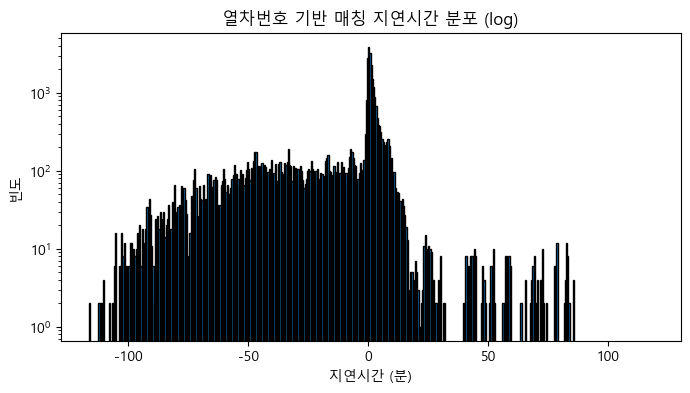

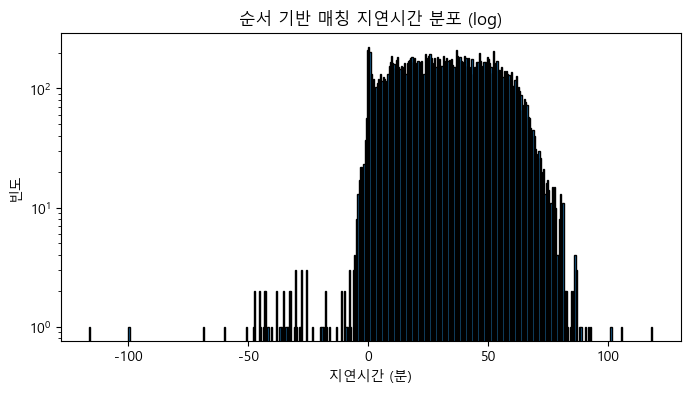

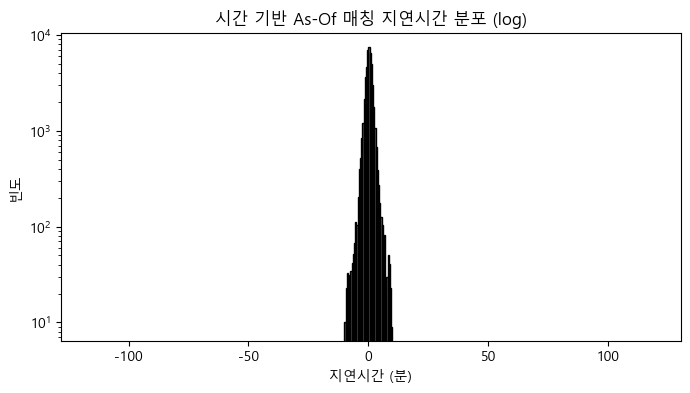

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import sys
from datetime import timedelta

# 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rc('axes', unicode_minus=False)

# ——————————————————————————————
# 설정
# ——————————————————————————————
date = '0529'
slot = 'morning'
service_date = '2025-05-29'

# 스케줄 파일은 현재 폴더(.ipynb와 동일)에 위치
schedule_template = './서울교통공사_서울 도시철도 열차운행시각표_20250430_{}_clean.csv'

# 실측 파일 탐색(재귀적)
real_candidates = glob.glob(f'**/all_{date}_{slot}_clean.csv', recursive=True)
if not real_candidates:
    print("실측 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    sys.exit()

real_path = real_candidates[0]

# 스케줄 파일 확인
sched_path = schedule_template.format(slot)
if not glob.glob(sched_path):
    print("스케줄 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    sys.exit()

# ——————————————————————————————
# 데이터 로드 및 전처리
# ——————————————————————————————
# 실측
real = pd.read_csv(real_path)
real['recptnDt'] = pd.to_datetime(real['recptnDt'], errors='coerce')
real['호선']     = real['subwayId'].map({1001:1,1002:2,1003:3,1004:4,1005:5,1006:6,1007:7,1008:8,1009:9})
real['방향']     = real['updnLine'].map({'상행':'UP','하행':'DOWN','내선':'IN','외선':'OUT'})
real['역사명']   = real['statnNm']
real['급행코드'] = real['btrainSttus'].map({'급행':1,'일반':0}).fillna(0).astype(int)
real['열차번호'] = real['btrainNo'].astype(str).str.extract(r'(\d+)')
real_df = real[['호선','방향','역사명','급행코드','열차번호','recptnDt']]

# 스케줄
sched = pd.read_csv(sched_path)
sched['열차도착시간'] = pd.to_datetime(sched['열차도착시간'], errors='coerce').dt.strftime('%H:%M:%S')
sched['예정시간']     = pd.to_datetime(service_date + ' ' + sched['열차도착시간'])
sched['호선']         = sched['호선']
sched['방향']         = sched['방향']
sched['역사명']       = sched['역사명']
sched['급행코드']     = sched['급행여부'].fillna(0).astype(int)
sched['열차번호']     = sched['열차코드'].astype(str).str.extract(r'(\d+)')
sched_df = sched[['호선','방향','역사명','급행코드','열차번호','예정시간']]

# ——————————————————————————————
# 지연시간 분포 계산 (컷 없음)
# ——————————————————————————————
distributions = {}

# 1) 열차번호 기반
m1 = pd.merge(sched_df, real_df,
              on=['호선','방향','역사명','급행코드','열차번호'], how='inner')
m1['delay_min'] = (m1['recptnDt'] - m1['예정시간']).dt.total_seconds() / 60
distributions['열차번호 기반'] = m1['delay_min']

# 2) 순서 기반
dist2 = []
for key, grp in sched_df.groupby(['호선','방향','역사명','급행코드']):
    real_grp = real_df[(real_df[['호선','방향','역사명','급행코드']] == key).all(axis=1)]
    if real_grp.empty: continue
    s = grp.sort_values('예정시간').reset_index(drop=True)
    r = real_grp.sort_values('recptnDt').reset_index(drop=True)
    n = min(len(s), len(r))
    delays = (r.loc[:n-1,'recptnDt'].values - s.loc[:n-1,'예정시간'].values) / np.timedelta64(1,'m')
    dist2.extend(delays)
distributions['순서 기반'] = pd.Series(dist2)

# 3) 시간 기반 As-Of
dist3 = []
for key, grp in sched_df.groupby(['호선','방향','역사명','급행코드']):
    real_grp = real_df[(real_df[['호선','방향','역사명','급행코드']] == key).all(axis=1)]
    if real_grp.empty: continue
    s = grp.sort_values('예정시간').reset_index(drop=True)
    r = real_grp.sort_values('recptnDt').reset_index(drop=True)
    out = pd.merge_asof(s[['예정시간']], r[['recptnDt']],
                        left_on='예정시간', right_on='recptnDt',
                        direction='nearest', tolerance=timedelta(minutes=10))
    delays = (out['recptnDt'] - out['예정시간']).dt.total_seconds() / 60
    dist3.extend(delays)
distributions['시간 기반 As-Of'] = pd.Series(dist3)

# ——————————————————————————————
# 히스토그램 그리기 (0.5분 간격)
# ——————————————————————————————
all_min = min(d.min() for d in distributions.values())
all_max = max(d.max() for d in distributions.values())
bins = np.arange(np.floor(all_min/0.5)*0.5, np.ceil(all_max/0.5)*0.5+0.5, 0.5)

for name, data in distributions.items():
    plt.figure(figsize=(8,4))
    plt.hist(data.dropna(), bins=bins, edgecolor='black')
    plt.xlabel('지연시간 (분)')
    plt.ylabel('빈도')
    plt.yscale('log')            # ← 추가: y축을 로그 스케일로
    plt.title(f'{name} 매칭 지연시간 분포 (log)')
    plt.show()


## 열차 번호 매핑 후 지연시간 그래프


-- Processing 0524 morning --
Real-time: data\0524\all_0524_morning_clean.csv | Exists: True
Schedule:   서울교통공사_서울 도시철도 열차운행시각표_20250430_morning_clean.csv | Exists: True
Matched records: 33065

-- Processing 0524 afternoon --
Real-time: data\0524\all_0524_afternoon_clean.csv | Exists: False
Schedule:   서울교통공사_서울 도시철도 열차운행시각표_20250430_afternoon_clean.csv | Exists: True
Skipping due to missing file(s)

-- Processing 0524 evening --
Real-time: data\0524\all_0524_evening_clean.csv | Exists: False
Schedule:   서울교통공사_서울 도시철도 열차운행시각표_20250430_evening_clean.csv | Exists: True
Skipping due to missing file(s)

-- Processing 0526 morning --
Real-time: data\0526\all_0526_morning_clean.csv | Exists: True
Schedule:   서울교통공사_서울 도시철도 열차운행시각표_20250430_morning_clean.csv | Exists: True
Matched records: 37065

-- Processing 0526 afternoon --
Real-time: data\0526\all_0526_afternoon_clean.csv | Exists: False
Schedule:   서울교통공사_서울 도시철도 열차운행시각표_20250430_afternoon_clean.csv | Exists: True
Skipping due to miss

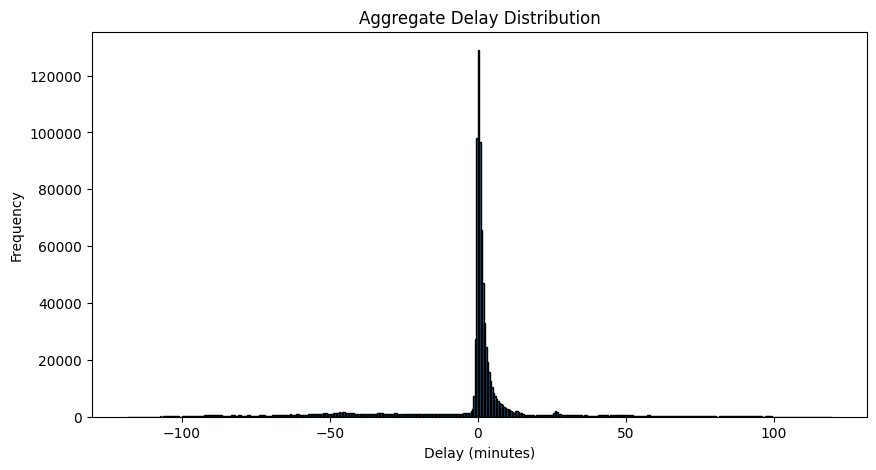

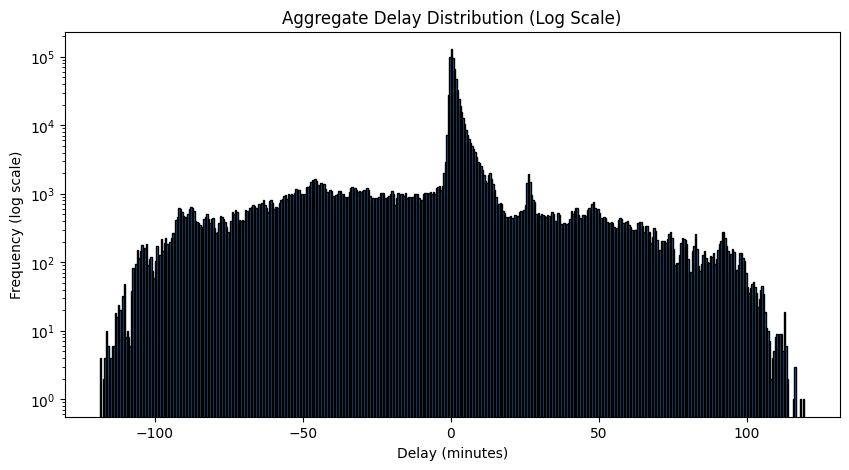

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 설정
base_dir = 'data'
year = 2025
time_slots = ['morning', 'afternoon', 'evening']
# 스케줄 파일은 현재 노트북(.ipynb)와 같은 디렉터리에 있음
schedule_template = '서울교통공사_서울 도시철도 열차운행시각표_20250430_{}_clean.csv'

all_delays = []

# 1) date_dirs 리스트
date_dirs = [
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()
]

# 2) 모든 날짜/시간대 순회
for date in sorted(date_dirs):
    for slot in time_slots:
        realtime_path = os.path.join(base_dir, date, f'all_{date}_{slot}_clean.csv')
        schedule_path = schedule_template.format(slot)  # cwd 기준

        print(f"\n-- Processing {date} {slot} --")
        print(f"Real-time: {realtime_path} | Exists: {os.path.exists(realtime_path)}")
        print(f"Schedule:   {schedule_path} | Exists: {os.path.exists(schedule_path)}")
        if not (os.path.exists(realtime_path) and os.path.exists(schedule_path)):
            print("Skipping due to missing file(s)")
            continue

        # 실측 로드
        real_df = pd.read_csv(realtime_path, parse_dates=['recptnDt'])
        real_df.rename(columns={'statnNm':'역사명'}, inplace=True)
        real_df['열차번호'] = real_df['btrainNo'].astype(str).str.extract(r'(\d+)')

        # 스케줄 로드
        sched_df = pd.read_csv(schedule_path)
        sched_df['열차도착시간'] = pd.to_datetime(sched_df['열차도착시간'], errors='coerce').dt.strftime('%H:%M:%S')
        service_date = f"{year}-{date[:2]}-{date[2:]}"
        sched_df['예정시간'] = pd.to_datetime(service_date + ' ' + sched_df['열차도착시간'])
        sched_df['열차번호'] = sched_df['열차코드'].astype(str).str.extract(r'(\d+)')

        # 매칭 및 지연 계산
        merged = pd.merge(
            sched_df[['예정시간','열차번호','역사명']],
            real_df[['recptnDt','열차번호','역사명']],
            on=['열차번호','역사명'], how='inner'
        ).dropna(subset=['예정시간','recptnDt'])
        delays = (merged['recptnDt'] - merged['예정시간']).dt.total_seconds() / 60
        print(f"Matched records: {len(delays)}")
        all_delays.append(delays)

# 3) 전체 지연 히스토그램
all_delays = pd.concat(all_delays, ignore_index=True)
bins = np.arange(
    np.floor(all_delays.min()/0.5)*0.5,
    np.ceil (all_delays.max()/0.5)*0.5 + 0.5,
    0.5
)
plt.figure(figsize=(10,5))
plt.hist(all_delays, bins=bins, edgecolor='black')

plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Aggregate Delay Distribution')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(all_delays, bins=bins, edgecolor='black')
plt.xlabel('Delay (minutes)')
plt.yscale('log')            # ← 추가: y축을 로그 스케일로
plt.ylabel('Frequency (log scale)')
plt.title('Aggregate Delay Distribution (Log Scale)')
plt.show()

In [41]:
p5  = all_delays.quantile(0.05)
p10  = all_delays.quantile(0.1)
p15  = all_delays.quantile(0.15)
p20  = all_delays.quantile(0.2)
p90 = all_delays.quantile(0.9)
p95 = all_delays.quantile(0.95)
print(f"하위 5% 지연시간: {p5:.2f} 분")
print(f"하위 10% 지연시간: {p10:.2f} 분")
print(f"하위 15% 지연시간: {p15:.2f} 분")
print(f"하위 20% 지연시간: {p20:.2f} 분")
print(f"상위 10% 지연시간: {p90:.2f} 분")
print(f"상위 5% 지연시간: {p95:.2f} 분")

하위 5% 지연시간: -55.80 분
하위 10% 지연시간: -36.70 분
하위 15% 지연시간: -14.35 분
하위 20% 지연시간: -0.78 분
상위 10% 지연시간: 8.97 분
상위 5% 지연시간: 29.68 분


## 배차간격

In [8]:
import os
import pandas as pd
from datetime import time

# ——————————————————————————————
# 설정 (스케줄 파일만 읽음)
# ——————————————————————————————
slots = ['morning', 'afternoon', 'evening']
# 스케줄 CSV가 .ipynb와 같은 폴더에 있어야 합니다
schedule_template = './서울교통공사_서울 도시철도 열차운행시각표_20250430_{}_clean.csv'
service_date = '2025-04-30'
ref_station  = '서울'  # '서울역'이 아니라 '서울'인 경우

# 시간대별 구간 (HH:MM:SS)
time_windows = {
    'morning':   ('07:30:00', '09:30:00'),
    'afternoon': ('12:00:00', '14:00:00'),
    'evening':   ('17:00:00', '19:00:00'),
}

def parse_hms(s: str) -> time:
    h, m, sec = s.split(':')
    return time(int(h), int(m), int(sec))


# ——————————————————————————————
# 계산: 스케줄만으로 배차간격
# ——————————————————————————————
for slot in slots:
    sched_path = schedule_template.format(slot)
    print(f"\n=== Slot: {slot.capitalize()} ===")
    if not os.path.exists(sched_path):
        print(f"  [스킵] 파일 없음: {sched_path}")
        continue

    # 1) 스케줄 로드
    sched = pd.read_csv(sched_path)

    # 2) ‘열차도착시간’ → ‘예정시간’ (datetime)
    sched['열차도착시간'] = pd.to_datetime(
        sched['열차도착시간'], errors='coerce'
    ).dt.strftime('%H:%M:%S')
    sched['예정시간'] = pd.to_datetime(
        service_date + ' ' + sched['열차도착시간'],
        format='%Y-%m-%d %H:%M:%S'
    )

    # 3) 기준역(서울) 필터
    sched_ref = sched[sched['역사명'] == ref_station].copy()
    if sched_ref.empty:
        print("  - 서울역(서울) 데이터 없음")
        continue

    # 4) 주중/주말 분리
    weekday_df = sched_ref[sched_ref['주중주말'] == 'DAY']
    weekend_df = sched_ref[sched_ref['주중주말'].isin(['SAT','END'])]

    for label, df_sel in [('Weekday', weekday_df), ('Weekend', weekend_df)]:
        print(f"\n  >> {label}")
        if df_sel.empty:
            print("    - 해당 구분 데이터 없음")
            continue

        # 5) 시간대별 slicing
        start_s, end_s = time_windows[slot]
        start_t, end_t = parse_hms(start_s), parse_hms(end_s)
        df_win = df_sel[
            df_sel['예정시간'].dt.time.between(start_t, end_t)
        ].sort_values(['호선','방향','예정시간']).reset_index(drop=True)

        if df_win.shape[0] < 2:
            print("    - 배차간격 계산 불가(데이터 부족)")
            continue

        # 6) 호선+방향별 배차간격 평균 계산
        for (line, direction), grp in df_win.groupby(['호선','방향']):
            grp = grp.reset_index(drop=True)
            grp['prev'] = grp['예정시간'].shift(1)
            grp['headway_min'] = (
                grp['예정시간'] - grp['prev']
            ).dt.total_seconds() / 60
            avg = grp['headway_min'].dropna().mean()
            print(f"    ▶ Line {line} {direction}: 평균 배차 간격 = {avg:.2f} 분")



=== Slot: Morning ===

  >> Weekday
    ▶ Line 1 DOWN: 평균 배차 간격 = 3.95 분
    ▶ Line 1 UP: 평균 배차 간격 = 3.90 분
    ▶ Line 4 DOWN: 평균 배차 간격 = 3.40 분
    ▶ Line 4 UP: 평균 배차 간격 = 3.44 분

  >> Weekend
    ▶ Line 1 DOWN: 평균 배차 간격 = 2.29 분
    ▶ Line 1 UP: 평균 배차 간격 = 2.19 분
    ▶ Line 4 DOWN: 평균 배차 간격 = 2.92 분
    ▶ Line 4 UP: 평균 배차 간격 = 2.88 분

=== Slot: Afternoon ===

  >> Weekday
    - 배차간격 계산 불가(데이터 부족)

  >> Weekend
    - 배차간격 계산 불가(데이터 부족)

=== Slot: Evening ===

  >> Weekday
    - 배차간격 계산 불가(데이터 부족)

  >> Weekend
    - 배차간격 계산 불가(데이터 부족)


In [ ]:
# 급행 구분 안함 -> 결과 별로임

# import pandas as pd
# import numpy as np
# import os
# from datetime import datetime, timedelta

# # ——————————————————————————————
# # 1) Asof 기반 1:1 매칭 함수 정의 (역별 매칭, 도착역 무시)
# # ——————————————————————————————
# def asof_one_to_one_match_by_station(sched_df, real_df, tol=timedelta(minutes=10)):
#     sched = sched_df.reset_index().rename(columns={'index': 'sched_idx'})
#     real  = real_df.reset_index().rename(columns={'index': 'real_idx'})

#     sched = sched.sort_values('예정시간').reset_index(drop=True)
#     real  = real.sort_values('recptnDt').reset_index(drop=True)

#     merged = pd.merge_asof(
#         sched[['sched_idx','예정시간','열차번호']],
#         real[['real_idx','recptnDt','열차번호']],
#         left_on='예정시간',
#         right_on='recptnDt',
#         direction='nearest',
#         tolerance=tol,
#         suffixes=('_sched','_real')
#     )

#     merged['diff_sec'] = (merged['recptnDt'] - merged['예정시간']).abs().dt.total_seconds()
#     merged['delay_sec'] = (merged['recptnDt'] - merged['예정시간']).dt.total_seconds()
#     merged['matched_real'] = ~merged['recptnDt'].isna()

#     matched = merged[merged['matched_real']].copy()
#     if not matched.empty:
#         matched = matched.sort_values(['real_idx','diff_sec'])
#         matched = matched.drop_duplicates(subset=['real_idx'], keep='first')

#     used_sched = set(matched['sched_idx']) if not matched.empty else set()
#     used_real  = set(matched['real_idx'])  if not matched.empty else set()

#     results = []
#     for _, row in matched.iterrows():
#         results.append({
#             'sched_idx':    int(row['sched_idx']),
#             'real_idx':     int(row['real_idx']),
#             'sched_train':  row['열차번호_sched'],
#             'real_train':   row['열차번호_real'],
#             '예정시간':     row['예정시간'],
#             '실제시간':     row['recptnDt'],
#             '지연시간(분)':  row['delay_sec'] / 60
#         })

#     for _, row in sched.iterrows():
#         idx = row['sched_idx']
#         if idx not in used_sched:
#             results.append({
#                 'sched_idx':    int(idx),
#                 'real_idx':     np.nan,
#                 'sched_train':  row['열차번호'],
#                 'real_train':   pd.NA,
#                 '예정시간':     row['예정시간'],
#                 '실제시간':     pd.NaT,
#                 '지연시간(분)':  np.nan
#             })

#     for _, row in real.iterrows():
#         idx = row['real_idx']
#         if idx not in used_real:
#             results.append({
#                 'sched_idx':    np.nan,
#                 'real_idx':     int(idx),
#                 'sched_train':  pd.NA,
#                 'real_train':   row['열차번호'],
#                 '예정시간':     pd.NaT,
#                 '실제시간':     row['recptnDt'],
#                 '지연시간(분)':  np.nan
#             })

#     return results

# # ——————————————————————————————
# # 2) 전체 분석 스크립트
# # ——————————————————————————————
# def run_asof_matching(date, year, realtime_path, schedule_path, output_path):
#     realtime_df = pd.read_csv(realtime_path)
#     schedule_df = pd.read_csv(schedule_path)

#     analysis_day = datetime.strptime(f'{year}{date}', '%Y%m%d')
#     weekday = analysis_day.weekday()
#     if date in ['0603', '0606']:
#         day_type = 'END'
#     else:
#         day_type = 'DAY' if weekday < 5 else 'SAT' if weekday == 5 else 'END'
#     schedule_df = schedule_df[schedule_df['주중주말'] == day_type].copy()

#     subway_map    = {1001:1,1002:2,1003:3,1004:4,1005:5,1006:6,1007:7,1008:8,1009:9}
#     direction_map = {'상행':'UP','하행':'DOWN','내선':'IN','외선':'OUT'}

#     realtime_df['recptnDt']  = pd.to_datetime(realtime_df['recptnDt'], errors='coerce')
#     realtime_df['호선']      = realtime_df['subwayId'].map(subway_map)
#     realtime_df['방향']      = realtime_df['updnLine'].map(direction_map)
#     realtime_df['역사명']    = realtime_df['statnNm']
#     realtime_df['열차번호']  = realtime_df['btrainNo'].astype(str).str.extract(r'(\d+)')
#     realtime_df['도착역']    = realtime_df['bstatnNm']

#     schedule_df['열차도착시간'] = pd.to_datetime(schedule_df['열차도착시간'], errors='coerce')
#     schedule_df['예정시간'] = schedule_df['열차도착시간'].dt.strftime('%H:%M:%S')
#     schedule_df['예정시간'] = pd.to_datetime(
#         f'{year}-{date[:2]}-{date[2:]}' + ' ' + schedule_df['예정시간'],
#         format='%Y-%m-%d %H:%M:%S', errors='coerce'
#     )
#     schedule_df['열차번호'] = schedule_df['열차코드'].astype(str).str.extract(r'(\d+)')
#     schedule_df['도착역']   = schedule_df['도착역']
#     schedule_df['역사명']   = schedule_df['역사명']

#     realtime_df = realtime_df.reset_index(drop=True)
#     schedule_df = schedule_df.reset_index(drop=True)

#     # 급행코드 제외
#     group_keys = ['호선', '방향', '역사명']

#     all_matches = []
#     for key_vals, sched_grp in schedule_df.groupby(group_keys):
#         line_id, direction, station = key_vals

#         cond = (
#             (realtime_df['호선'] == line_id) &
#             (realtime_df['방향'] == direction) &
#             (realtime_df['역사명'] == station)
#         )
#         real_grp = realtime_df[cond].copy()

#         matches = asof_one_to_one_match_by_station(
#             sched_grp[['예정시간','열차번호']],
#             real_grp[['recptnDt','열차번호']],
#             tol=timedelta(minutes=10)
#         )
#         for m in matches:
#             m.update({
#                 '호선':   line_id,
#                 '방향':   direction,
#                 '역사명': station
#             })
#         all_matches.extend(matches)

#     result_df = pd.DataFrame(all_matches)

#     cols = [
#         '호선', '방향', '역사명',
#         'sched_train', 'real_train',
#         '예정시간', '실제시간', '지연시간(분)'
#     ]
#     result_df = result_df[cols]

#     os.makedirs(os.path.dirname(output_path), exist_ok=True)
#     result_df.to_csv(output_path, index=False, encoding='utf-8-sig')

# # 실행 루프
# base_dir = 'data'
# year = 2025
# time_slots = ['morning', 'afternoon', 'evening']
# schedule_template = '서울교통공사_서울 도시철도 열차운행시각표_20250430_{}_clean.csv'

# date_dirs = [
#     d for d in os.listdir(base_dir)
#     if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()
# ]

# for date in sorted(date_dirs):
#     for time_of_day in time_slots:
#         realtime_path = f'{base_dir}/{date}/all_{date}_{time_of_day}_clean.csv'
#         schedule_path = schedule_template.format(time_of_day)
#         output_path   = f'{base_dir}/{date}/new_delay_{date}_{time_of_day}.csv'

#         # 기존 결과 파일 있으면 skip
#         if os.path.exists(output_path):
#             continue

#         if not (os.path.exists(realtime_path) and os.path.exists(schedule_path)):
#             print(f'Skipping: missing file(s) for {date} {time_of_day}')
#             continue

#         print(f'Running asof match: {date} {time_of_day}')
#         try:
#             run_asof_matching(date, year, realtime_path, schedule_path, output_path)
#         except Exception as e:
#             print(f'Failed for {date} {time_of_day}: {e}')


## Visualization

In [ ]:
# line = 1 # 호선 변경하기
# time_of_day = 'morning' # 시간대 변경하기
# dates = {
#     'Weekday (0519)': '0519',
#     'Weekend (0525)': '0525'
# }

# direction_label_map = {
#     '상행': 'Up',
#     '하행': 'Down'
# }

# fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# for idx, direction in enumerate(['상행', '하행']):
#     ax = axes[idx]
#     delay_all = []

#     for label, date in dates.items():
#         filename = f'서울_line{line}_{date}_{time_of_day}_delay.csv'
#         if not os.path.exists(filename):
#             continue
#         df = pd.read_csv(filename)
#         if 'updnLine' not in df.columns or df.empty:
#             continue
#         df_dir = df[df['updnLine'] == direction]
#         if df_dir.empty:
#             continue
#         delay_all.extend(df_dir['delay_min'].dropna().tolist())
    
#     if not delay_all:
#         print(f'No delay data found for direction {direction}')
#         continue

#     dmin, dmax = int(np.floor(min(delay_all))), int(np.ceil(max(delay_all)))
#     bins = np.arange(dmin, dmax + 1)

#     for label, date in dates.items():
#         filename = f'서울_line{line}_{date}_{time_of_day}_delay.csv'
#         if not os.path.exists(filename):
#             continue
#         df = pd.read_csv(filename)
#         df_dir = df[df['updnLine'] == direction]
#         if df_dir.empty:
#             continue
#         counts, edges = np.histogram(df_dir['delay_min'], bins=bins)
#         centers = (edges[:-1] + edges[1:]) / 2
#         ax.plot(centers, counts, label=label, marker='o')
    
#     label_eng = direction_label_map.get(direction, direction)
#     ax.axvline(0, color='gray', linestyle='--', label='Scheduled Time')
#     ax.set_title(f'{label_eng}', fontsize=13)
#     ax.set_xlabel('Delay (minutes)')
#     ax.grid(axis='y', linestyle=':', alpha=0.6)
#     ax.set_xticks(bins)
#     if idx == 0:
#         ax.set_ylabel('Number of subways')
#     ax.legend()

# plt.suptitle(f'Arrival Delay Distribution by Direction\nSeoul Station Line {line} (07:30-09:30)', fontsize=15) # 시간 범위 변경하기
# plt.tight_layout(rect=[0, 0, 1, 0.93])
# plt.show()

In [ ]:

# #— 설정 부분만 바꿔가며 사용하세요 —#
# date = '0529'                     # 예: '0529', '0603' 등
# time_of_day = 'evening'           # 'morning' / 'afternoon' / 'evening'
# #———————————————#

# # 1) 전처리된 all_{date}_{time_of_day}_clean.csv 파일 경로
# input_path = f'data/{date}/all_{date}_{time_of_day}.csv'

# # 2) 출력할 필터링 결과 파일 경로
# output_dir  = f'data/{date}/'
# output_file = f'filtered_{date}_{time_of_day}.csv'
# output_path = os.path.join(output_dir, output_file)

# # (폴더가 없으면 미리 생성)
# os.makedirs(output_dir, exist_ok=True)

# # 3) CSV 읽기 (recptnDt 칼럼을 datetime으로 파싱)
# df_all = pd.read_csv(input_path, encoding='utf-8-sig', parse_dates=['recptnDt'])

# # 4) 역사명(statnNm)이 '서울'인 행만 남기기
# #    원본 API에서는 '서울역'을 '서울'로 표기하는 경우가 많습니다.
# #    만약 '서울역'이 정확히 들어가 있다면, '==' 대신 .str.contains('서울역') 등을 사용하세요.
# filtered = df_all[df_all['subwayId'] == 1009].copy()


# # 5) 결과 저장
# filtered.to_csv(output_path, index=False, encoding='utf-8-sig')

# print(f'필터링된 파일이 저장되었습니다: {output_path}')